## Scaling of Semantic Diversity in MSAs

In this notebook we will calculate measures for states and cities and see how they scale.

In [1]:
import csv
import json
import operator

In [2]:
import numpy as np

In [3]:
def read_vectors(file_name):
    line = open(file_name, "r")
    for l in line:
        d = eval(l)
    return d

In [4]:
research_cities = read_vectors("../saved_data_structures/research_vectors_cities_cleaned.txt")

In [5]:
research_orgs = read_vectors("../saved_data_structures/research_vectors_orgs_cleaned.txt")

In [6]:
teaching_cities = read_vectors("../saved_data_structures/teaching_vectors_cities_cleaned.txt")

In [7]:
teaching_orgs = read_vectors("../saved_data_structures/teaching_vectors_orgs_cleaned.txt")

In [8]:
import string

In [9]:
def convertabrv(entity, city=False):
    """
    converts uni/city into non abbreviated form.
    """
    stop_words = ['of', 'the', 'at', 'and']
    replace = {'univ':'university', 'res':'research', 'med':'medical', 'coll':'college', 'ctr':'center', 'jr':'junior',
               'inst':'institute', 'nat':'natural', 'htlh':'health', 'calif':'california', 'sci':'science', 'adv':'advanced',
               'ut':'university texas', 'n':'north', 's':'south', 'e': 'east', 'w': 'west', 'natl':'national',
               'uc':'university california', 'pk':'park', 'ft':'fort', 'so':'southern', 'no':'northern', 'syst':'system',
               'technol':'technology', 'penn':'pennsylvania', 'hosp':'hospital', 'clin':'clinic', 'mt':'mount',
               'biomed':'biomedical', 'canc':'cancer', 'nw':'northwestern', 'cuny':'city university new york',
                'suny':'state university new york', 'unc':'university north carolina', 'mit':'massachusetts institute technology',
               'caltech':'california institute technology', 'gen':'general', 'nyu':'new york university',
               'iit':'illionis institute technology', 'inc':'incorporated', 'fdn':'foundation'}
    stop_chars = ['-']
    remove_chars = ['&']
    entity_ = entity.lower()
    
    for chars in stop_chars:
        entity_ = entity_.replace(chars, " ")
    
    for chars in remove_chars:
        entity_ = entity_.replace(chars, "")
    
    for word in replace:
        entity_ = re.sub(r'\b%s\b' % word, replace[word], entity_)
    
    for word in stop_words:
        entity_ = re.sub(r'\b%s\b' % word, " ", entity_)
    
    entity_ = entity_.strip()
    entity_ = re.sub(' +', ' ', entity_)
    
    if city:
        return(string.capwords(entity_))
    
    return entity_

In [10]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

In [11]:
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    if v1 is None or v2 is None:
        return (None, None)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    cos = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
    return np.arccos(cos)*57.2958 , cos

In [12]:
reader = csv.reader(open("../saved_data_structures/city_unis.csv"))

In [13]:
len(research_cities)

7559

In [14]:
cities = {}

In [15]:
for k,v in reader:
    cities[k] = eval(v)

In [16]:
len(cities)

1284

In [17]:
list(research_cities.keys())[0:20]

['Berkeley',
 'Baltimore',
 'Washington',
 'New Brunswick',
 'University Pk',
 'Argonne',
 'Cincinnati',
 'Chicago',
 'Seattle',
 'Houston',
 'Los Angeles',
 'San Antonio',
 'Indianapolis',
 'Toledo',
 'Columbus',
 'Boston',
 'W Roxbury',
 'Notre Dame',
 'Ames',
 'San Diego']

In [18]:
list(cities.keys())[0:20]

['San Angelo',
 'University',
 'Medford',
 'Los Altos Hills',
 'Athens',
 'Union',
 'Jackson',
 'Tuscaloosa',
 'Lansing',
 'Hobbs',
 'Carrollton',
 'Parkville',
 'Nacogdoches',
 'Albany',
 'Galveston',
 'Seattle',
 'Houston',
 'Commerce',
 'College Park',
 'Clemson']

### Scaling Data for Cities and States



In [19]:
import xlrd

In [20]:
wb = xlrd.open_workbook("../saved_data_structures/cbsa-report-chapter-1-data.xlsx")

In [21]:
metropolitan_area = wb.sheet_by_index(0)

In [22]:
principal_cities = wb.sheet_by_index(1)

In [23]:
principal_cities.nrows

2287

In [24]:
city_pops = {}

In [25]:
for i in range(0, principal_cities.nrows):
    if 'city' in principal_cities.cell(i, 2).value:
        city, rest = principal_cities.cell(i, 2).value.split('city')
        city = city.strip()
        if city not in city_pops:
            city_pops[city] = int(principal_cities.cell(i, 3).value)
        else:
            pop = city_pops[city]
            pop_ = int(principal_cities.cell(i, 3).value)
            max_pop = max(pop, pop_)
            min_pop = min(pop, pop_)
            city_pops[city] = max_pop
            city_pops[principal_cities.cell(i, 2).value] = min_pop

In [26]:
city_pops['Ithaca']

30014

In [27]:
len(city_pops)

1158

## Scaling by MSA



In [28]:
msa_cities = {}
msa_pop = {}

In [29]:
for i in range(0, principal_cities.nrows):
    if 'Metro Area' in principal_cities.cell(i, 2).value or 'Micro Area' in principal_cities.cell(i, 2).value:
        current_msa = principal_cities.cell(i, 2).value
        msa_pop[current_msa] = int(principal_cities.cell(i, 3).value)
        msa_cities[current_msa] = []
    if 'city' in principal_cities.cell(i, 2).value:
        city, rest = principal_cities.cell(i, 2).value.split('city')
        city = city.strip()
        msa_cities[current_msa].append(city)


In [30]:
del_names = []

In [31]:
for msa in msa_cities:
    try:
        city_0, _ = msa.split(',')
    except:
        continue
    for msa_1 in msa_cities:
        try:
            city_1, _ = msa_1.split(',')
        except:
            continue
        if city_0 == city_1:
            if msa_pop[msa] > msa_pop[msa_1]:
                del_names.append(msa_1)

In [32]:
for name in del_names:
    try:
        del msa_cities[name]
    except:
        print("cities error " + name)
    try:
        del msa_pop[name]
    except:
        print("pop error " + name)

cities error Columbia, TN Micro Area
pop error Columbia, TN Micro Area
cities error Columbus, MS Micro Area
pop error Columbus, MS Micro Area
cities error Columbus, NE Micro Area
pop error Columbus, NE Micro Area
cities error Columbus, IN Metro Area
pop error Columbus, IN Metro Area
cities error Columbus, MS Micro Area
pop error Columbus, MS Micro Area
cities error Columbus, NE Micro Area
pop error Columbus, NE Micro Area
cities error Danville, KY Micro Area
pop error Danville, KY Micro Area
cities error Decatur, IN Micro Area
pop error Decatur, IN Micro Area
cities error Gainesville, TX Micro Area
pop error Gainesville, TX Micro Area
cities error Jackson, TN Metro Area
pop error Jackson, TN Metro Area
cities error Jackson, WY-ID Micro Area
pop error Jackson, WY-ID Micro Area
cities error Jackson, WY-ID Micro Area
pop error Jackson, WY-ID Micro Area
cities error Jacksonville, IL Micro Area
pop error Jacksonville, IL Micro Area
cities error Jacksonville, TX Micro Area
pop error Jacksonv

In [33]:
msa_unis = {}

In [34]:
for msa in msa_cities:
    msa_unis[msa] = []
    for city in msa_cities[msa]:
        if city in cities:
            for uni in cities[city]:
                msa_unis[msa].append(uni)
    if len(msa_unis[msa]) == 0:
        del msa_unis[msa]


In [35]:
msa_unis

{'Abilene, TX Metro Area': ['Abilene Christian University',
  'McMurry University',
  'Hardin-Simmons University'],
 'Akron, OH Metro Area': ['University of Akron Main Campus'],
 'Albany, GA Metro Area': ['Excelsior College',
  'Linn-Benton Community College',
  'SUNY at Albany',
  'Albany State University',
  'The College of Saint Rose',
  'Darton State College',
  'Albany Law School',
  'Albany College of Pharmacy and Health Sciences'],
 'Albany-Schenectady-Troy, NY Metro Area': ['Excelsior College',
  'Linn-Benton Community College',
  'SUNY at Albany',
  'Albany State University',
  'The College of Saint Rose',
  'Darton State College',
  'Albany Law School',
  'Albany College of Pharmacy and Health Sciences',
  'Union College-Schenectady',
  'Union Graduate College',
  'Rensselaer Polytechnic Institute',
  'Troy University',
  'Walsh College of Accountancy and Business Administration',
  'Hudson Valley Community College',
  'The Sage Colleges'],
 'Albuquerque, NM Metro Area': ['Un

In [120]:
msa_unis['Albany, GA Metro Area'] = ['Darton State College']

In [121]:
msa_unis['Albany-Schenectady-Troy, NY Metro Area'].remove('Linn-Benton Community College')

In [122]:
msa_unis['Albany-Schenectady-Troy, NY Metro Area'].remove('Darton State College')

### Research and Teaching Measures

In [36]:
import json

In [37]:
with open("../saved_data_structures/teaching_to_research_matching.txt") as file:
    teaching_to_research = json.load(file)

In [38]:
teaching_to_research_match = {}

In [39]:
for teach_org in teaching_to_research:
    if teaching_to_research[teach_org][1] > 90:
        teaching_to_research_match[teach_org] = teaching_to_research[teach_org][0]

In [40]:
teaching_to_research_match['University of California-Berkeley'] = 'Univ Calif Berkeley'

In [41]:
teaching_to_research_match['University of Washington-Seattle Campus'] = 'Univ Washington'

In [42]:
teaching_to_research_match['Georgia Institute of Technology-Main Campus'] = 'Georgia Tech'

In [43]:
teaching_to_research_match['University of Pittsburgh-Pittsburgh Campus'] = 'Univ Pittsburgh'

In [44]:
teaching_to_research_match['Ohio State University-Main Campus'] = 'Ohio State Univ'

In [45]:
teaching_to_research_match['Texas A & M University-College Station'] = 'Texas A&M Univ'

In [46]:
research_to_teaching_match = dict((v, k) for k, v in teaching_to_research_match.items())

In [47]:
def get_entity_vector(entity):
    # get teaching name
    try:
        teaching_uni_1_vector = teaching_orgs[entity][0]
    except KeyError:
        teaching_uni_1_vector = None
    # get research name
    try:
        research_uni_1 = teaching_to_research_match[entity]
        research_vector_1 = research_orgs[research_uni_1][0]
    except KeyError:
        if entity == "New York University":
            research_uni_1 = "NYU"
            research_vector_1 = research_orgs[research_uni_1][0]
        if entity == "University of Pennsylvania":
            research_uni_1 = "UPenn"
            research_vector_1 = research_orgs[research_uni_1][0]
        else:
            research_vector_1 = None
    return teaching_uni_1_vector, research_vector_1

In [148]:
msa_research_vectors = {}

In [149]:
msa_teaching_vectors = {}

In [150]:
for msa in msa_unis:
    msa_research_vectors[msa] = []
    msa_teaching_vectors[msa] = []
    for uni in msa_unis[msa]:
        teaching_vector, research_vector = get_entity_vector(uni)
        
        if teaching_vector is None:
            print("missing teaching vector is " + uni)
        else:
            msa_teaching_vectors[msa].append(teaching_vector)
        
        if research_vector is None:
            print("missing reserach vector is " + uni)
        else:
            msa_research_vectors[msa].append(research_vector)
    
    msa_research_vectors[msa] = np.mean(msa_research_vectors[msa], axis=0)
    msa_teaching_vectors[msa] = np.mean(msa_teaching_vectors[msa], axis=0)
    
    if msa_research_vectors[msa] is 

missing reserach vector is University of Akron Main Campus
missing reserach vector is Albany Law School
missing reserach vector is Union College-Schenectady
missing reserach vector is Union Graduate College
missing reserach vector is Walsh College of Accountancy and Business Administration
missing reserach vector is University of New Mexico-Main Campus
missing reserach vector is Alexandria Technical & Community College
missing reserach vector is Cedar Crest College
missing reserach vector is Northampton County Area Community College
missing reserach vector is Anderson University-Anderson
missing reserach vector is Concordia University-Ann Arbor
missing reserach vector is Miami University-Oxford
missing reserach vector is Fox Valley Technical College
missing reserach vector is Atlanta's John Marshall Law School
missing teaching vector is Morehouse School of Medicine
missing reserach vector is Morehouse School of Medicine
missing reserach vector is Chattahoochee Technical College
missing

In [48]:
within_msa_angles_rr = {}
between_msa_angles_rr = {}

within_msa_angles_rt = {}
within_msa_angles_rt_self = {}

within_msa_angles_tt = {}
between_msa_angles_tt = {}

In [49]:
missing_unis_research_msa = []
missing_unis_teaching_msa = []

In [50]:
for msa in msa_unis:
    
        
    if len(msa_unis[msa]) < 2:
        continue
    
    within_msa_angles_rr[msa] = 0
    within_msa_angles_tt[msa] = 0
    within_msa_angles_rt[msa] = 0
    within_msa_angles_rt_self[msa] = 0

    no_checks_rr = 0
    no_checks_tt = 0
    no_checks_rt = 0
    no_checks_self = 0

    
    for uni_1 in msa_unis[msa]:
        
        teaching_vector_1, research_vector_1 = get_entity_vector(uni_1)
        
        if teaching_vector_1 is not None and research_vector_1 is not None:
            within_msa_angles_rt_self[msa] += angle_between(research_vector_1, teaching_vector_1)[0]
            no_checks_self += 1
            
        if teaching_vector_1 is None:
            missing_unis_teaching_msa.append(uni_1)
            
        if research_vector_1 is None:
            missing_unis_research_msa.append(uni_1)
            
        for uni_2 in msa_unis[msa]:
            
            if uni_1 == uni_2:
                continue
            
            teaching_vector_2, research_vector_2 = get_entity_vector(uni_2)
            
            if research_vector_1 is not None and research_vector_2 is not None:
                within_msa_angles_rr[msa] += angle_between(research_vector_1, research_vector_2)[0]
                no_checks_rr += 1
            
            if teaching_vector_1 is not None and teaching_vector_2 is not None:
                within_msa_angles_tt[msa] += angle_between(teaching_vector_1, teaching_vector_2)[0]
                no_checks_tt += 1                
            
            if research_vector_1 is not None and research_vector_2 is not None and teaching_vector_1 is not None and teaching_vector_2 is not None:
                within_msa_angles_rt[msa] += angle_between(research_vector_1, teaching_vector_2)[0] + angle_between(teaching_vector_1, research_vector_2)
                no_checks_rt += 2
    try:
        within_msa_angles_rt_self[msa] = np.round(within_msa_angles_rt_self[msa] / no_checks_self, 3)
    except ZeroDivisionError:
        pass
    try:
        within_msa_angles_rr[msa] = np.round(within_msa_angles_rr[msa] / no_checks_rr, 3)
    except ZeroDivisionError:
        pass
    try:
        within_msa_angles_tt[msa] = np.round(within_msa_angles_tt[msa] / no_checks_tt, 3)
    except ZeroDivisionError:
        pass
    try:
        within_msa_angles_rt[msa] = np.round(within_msa_angles_rt[msa] / no_checks_rt, 3)
    except ZeroDivisionError:
        pass

In [51]:
import seaborn as sns

In [52]:
import matplotlib.pyplot as plt

In [53]:
def analyse_cities(cities, rev=True, label=None):
    angles = list(cities.values())
    angles = list(filter((0).__ne__, angles))
    ax = sns.distplot(angles)
    ax.set(xlabel="Angles", ylabel="Proportion of Counts", title="Distribution of Angles for " + str(label))
    plt.show()
    sorted_vals = sorted(cities.items(), key=operator.itemgetter(1))
    if rev:
        sorted_vals.reverse()
        return sorted_vals
    else:
        return sorted_vals

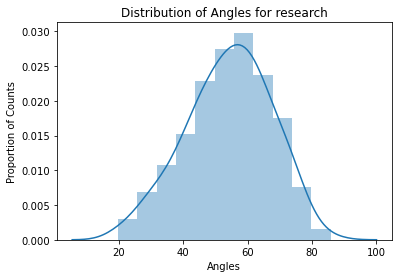

In [54]:
sorted_rr_msa = analyse_cities(within_msa_angles_rr, label="research")

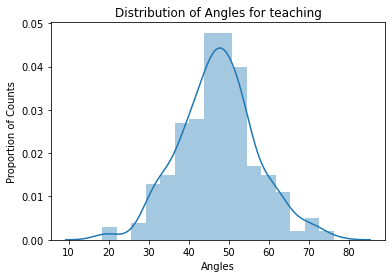

In [55]:
sorted_rr_msa = analyse_cities(within_msa_angles_tt, label="teaching")

In [56]:
sorted_rr_msa[0:10]

[('Greensburg, IN Micro Area', 76.18),
 ('Rocky Mount, NC Metro Area', 72.673),
 ('Pendleton-Hermiston, OR Micro Area', 71.698),
 ('Johnstown, PA Metro Area', 70.807),
 ('Longview, TX Metro Area', 70.254),
 ('Houghton, MI Micro Area', 70.046),
 ('Alexandria, LA Metro Area', 69.896),
 ('Fremont, OH Micro Area', 67.916),
 ('Centralia, WA Micro Area', 66.617),
 ('Greenwood, SC Micro Area', 65.269)]

In [57]:
for msa_angle in sorted_rr_msa[0:50]:
    msa, angle = msa_angle
    print(msa, angle, len(msa_unis[msa]))

Greensburg, IN Micro Area 76.18 2
Rocky Mount, NC Metro Area 72.673 2
Pendleton-Hermiston, OR Micro Area 71.698 2
Johnstown, PA Metro Area 70.807 2
Longview, TX Metro Area 70.254 2
Houghton, MI Micro Area 70.046 2
Alexandria, LA Metro Area 69.896 2
Fremont, OH Micro Area 67.916 2
Centralia, WA Micro Area 66.617 2
Greenwood, SC Micro Area 65.269 2
Sumter, SC Metro Area 64.97 2
Roanoke, VA Metro Area 64.796 2
Tuscaloosa, AL Metro Area 64.497 3
Parkersburg-Marietta-Vienna, WV-OH Metro Area 64.481 6
Newton, IA Micro Area 64.411 2
Batesville, AR Micro Area 62.555 2
Appleton, WI Metro Area 62.251 2
Bismarck, ND Metro Area 62.182 2
Lancaster, PA Metro Area 61.885 5
Elizabeth City, NC Micro Area 61.85 3
Mobile, AL Metro Area 61.535 3
Bellingham, WA Metro Area 61.397 4
Galesburg, IL Micro Area 61.04 2
Boise City-Nampa, ID Metro Area 60.98 2
Jefferson City, MO Metro Area 60.927 2
Sioux City, IA-NE-SD Metro Area 60.764 3
Watertown-Fort Drum, NY Micro Area 60.368 2
Watertown-Fort Atkinson, WI Micr

In [58]:
for msa_angle in sorted_rr_msa[200:300]:
    msa, angle = msa_angle
    print(msa, angle, len(msa_unis[msa]))

Tallahassee, FL Metro Area 41.878 3
Dallas-Fort Worth-Arlington, TX Metro Area 41.816 17
East Liverpool-Salem, OH Micro Area 41.79 5
Salem, OR Metro Area 41.79 5
Beaumont-Port Arthur, TX Metro Area 41.481 2
Poughkeepsie-Newburgh-Middletown, NY Metro Area 41.441 5
Victoria, TX Metro Area 41.435 2
Deltona-Daytona Beach-Ormond Beach, FL Metro Area 41.202 2
Lafayette, LA Metro Area 40.962 2
Virginia Beach-Norfolk-Newport News, VA-NC Metro Area 40.926 10
Abilene, TX Metro Area 40.889 3
Madison, WI Metro Area 40.635 7
Gainesville, FL Metro Area 40.612 4
Washington, NC Micro Area 40.59 9
Visalia-Porterville, CA Metro Area 40.469 2
Richmond, VA Metro Area 40.245 6
Syracuse, NY Metro Area 40.036 5
Corpus Christi, TX Metro Area 40.03 2
Marshall, TX Micro Area 40.018 3
Waterloo-Cedar Falls, IA Metro Area 39.934 2
Flint, MI Metro Area 39.933 3
Clinton, IA Micro Area 39.347 3
Kalamazoo-Portage, MI Metro Area 39.262 3
Killeen-Temple-Fort Hood, TX Metro Area 39.17 2
Richmond-Berea, KY Micro Area 39.0

In [90]:
from sklearn.linear_model import LinearRegression

In [102]:
def loglogfit(X, Y, xlabel="log(Population)", ylabel="log(Count)", title="Scaling plot"):
    log_x = np.log(X).reshape(-1, 1)
    log_y = np.log(Y).reshape(-1, 1)
    reg = LinearRegression().fit(log_x, log_y)
    preds = reg.predict(log_x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.scatter(log_x, log_y)
    plt.plot(log_x, preds, color='black', linewidth=3)
    print("Score on fitting data: " + str(reg.score(log_x, log_y)))
    print("Coefficient value: " + str(reg.coef_[0]))

In [59]:
import matplotlib.pyplot as plt

In [258]:
x_msa_pops = []
y_msa_rrs = []

In [259]:
for msa in within_msa_angles_rr:
    if msa in msa_pop and within_msa_angles_rr[msa] > 0:
        x_msa_pops.append(msa_pop[msa])
        y_msa_rrs.append(within_msa_angles_rr[msa])
        print(msa, msa_pop[msa])

Abilene, TX Metro Area 165252
Albany, GA Metro Area 157308
Albany-Schenectady-Troy, NY Metro Area 870716
Allentown-Bethlehem-Easton, PA-NJ Metro Area 821173
Ann Arbor, MI Metro Area 344791
Asheville, NC Metro Area 424858
Atlanta-Sandy Springs-Marietta, GA Metro Area 5268860
Austin-Round Rock-San Marcos, TX Metro Area 1716289
Bakersfield-Delano, CA Metro Area 839631
Baltimore-Towson, MD Metro Area 2710489
Baton Rouge, LA Metro Area 802484
Beaumont-Port Arthur, TX Metro Area 388745
Bellingham, WA Metro Area 201140
Billings, MT Metro Area 158050
Birmingham-Hoover, AL Metro Area 1128047
Bloomington, IN Metro Area 192714
Bloomington-Normal, IL Metro Area 169572
Boise City-Nampa, ID Metro Area 616561
Boston-Cambridge-Quincy, MA-NH Metro Area 4552402
Bridgeport-Stamford-Norwalk, CT Metro Area 916829
Brunswick, GA Metro Area 112370
Burlington, NC Metro Area 151131
Burlington-South Burlington, VT Metro Area 211261
Canton-Massillon, OH Metro Area 404422
Cape Coral-Fort Myers, FL Metro Area 61875

In [62]:
avg_within_angle_rr = 0

In [64]:
for msa in within_msa_angles_rr:
    avg_within_angle_rr += within_msa_angles_rr[msa]
avg_within_angle_rr = float(avg_within_angle_rr / len(within_msa_angles_rr))

In [65]:
avg_within_angle_rr

41.985854092526665

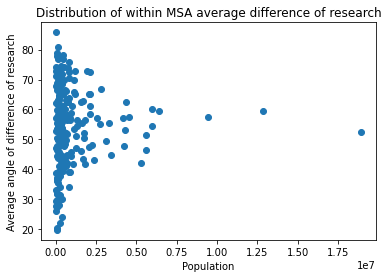

In [260]:
plt.title('Distribution of within MSA average difference of research')
plt.xlabel('Population')
plt.ylabel('Average angle of difference of research')
plt.scatter(x_msa_pops, y_msa_rrs)

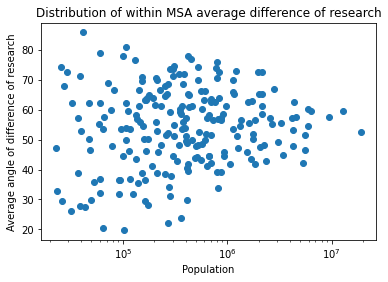

In [261]:
plt.xscale('log')
plt.title('Distribution of within MSA average difference of research')
plt.xlabel('Population')
plt.ylabel('Average angle of difference of research')
plt.scatter(x_msa_pops, y_msa_rrs)

Score on fitting data: 0.029877292033486547
Coefficient value: [0.03429536]


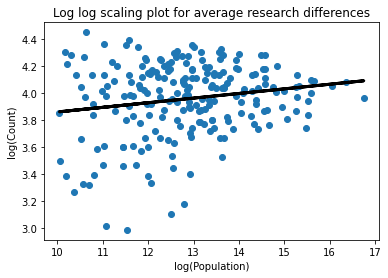

In [262]:
loglogfit(x_msa_pops, y_msa_rrs, title='Log log scaling plot for average research differences')

In [263]:
x_msa_pops = []
y_msa_tts = []

In [264]:
for msa in within_msa_angles_tt:
    if msa in msa_pop and within_msa_angles_tt[msa] > 0:
        x_msa_pops.append(msa_pop[msa])
        y_msa_tts.append(within_msa_angles_tt[msa])
        print(msa, msa_pop[msa])

Abilene, TX Metro Area 165252
Albany, GA Metro Area 157308
Albany-Schenectady-Troy, NY Metro Area 870716
Albuquerque, NM Metro Area 887077
Alexandria, LA Metro Area 153922
Allentown-Bethlehem-Easton, PA-NJ Metro Area 821173
Ann Arbor, MI Metro Area 344791
Appleton, WI Metro Area 225666
Asheville, NC Metro Area 424858
Atlanta-Sandy Springs-Marietta, GA Metro Area 5268860
Auburn-Opelika, AL Metro Area 140247
Austin-Round Rock-San Marcos, TX Metro Area 1716289
Bakersfield-Delano, CA Metro Area 839631
Baltimore-Towson, MD Metro Area 2710489
Baton Rouge, LA Metro Area 802484
Beaumont-Port Arthur, TX Metro Area 388745
Bellingham, WA Metro Area 201140
Billings, MT Metro Area 158050
Birmingham-Hoover, AL Metro Area 1128047
Bismarck, ND Metro Area 108779
Bloomington, IN Metro Area 192714
Bloomington-Normal, IL Metro Area 169572
Boise City-Nampa, ID Metro Area 616561
Boston-Cambridge-Quincy, MA-NH Metro Area 4552402
Boulder, CO Metro Area 294567
Bowling Green, KY Metro Area 125953
Bridgeport-Sta

In [71]:
len(x_msa_pops), len(y_msa_tts)

(278, 278)

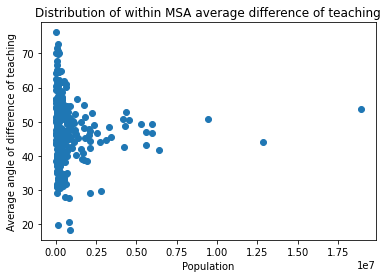

In [255]:
plt.title('Distribution of within MSA average difference of teaching')
plt.xlabel('Population')
plt.ylabel('Average angle of difference of teaching')
plt.scatter(x_msa_pops, y_msa_tts)

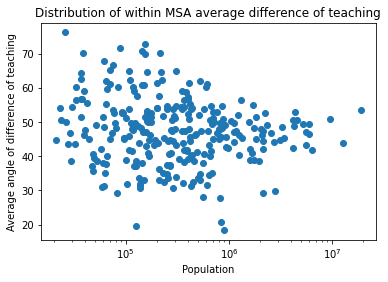

In [256]:
plt.xscale('log')
plt.title('Distribution of within MSA average difference of teaching')
plt.xlabel('Population')
plt.ylabel('Average angle of difference of teaching')
plt.scatter(x_msa_pops, y_msa_tts)

Score on fitting data: 0.01641335486189932
Coefficient value: [-0.02043196]


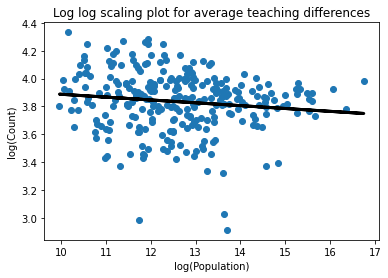

In [265]:
loglogfit(x_msa_pops, y_msa_tts, title='Log log scaling plot for average teaching differences')

### Scaling with count of papers, unis, syllabi



In [267]:
unis_per_msa = []

In [268]:
pop_per_msa = []

In [269]:
for msa in msa_unis:
    try:
        pop_per_msa.append(msa_pop[msa])
        unis_per_msa.append(len(msa_unis[msa]))
    except KeyError:
        print(msa)
        continue


In [270]:
import matplotlib.pyplot as plt

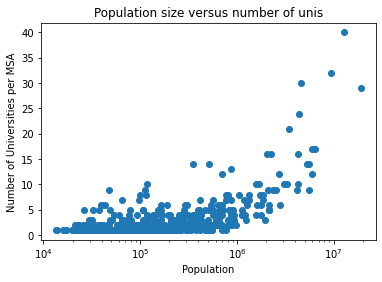

In [271]:
plt.xscale('log')
plt.title('Population size versus number of unis')
plt.xlabel('Population')
plt.ylabel('Number of Universities per MSA')
plt.scatter(pop_per_msa, unis_per_msa)

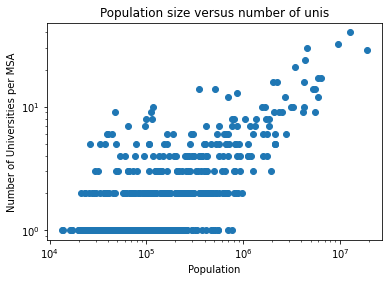

In [272]:
plt.xscale('log')
plt.yscale('log')
plt.title('Population size versus number of unis')
plt.xlabel('Population')
plt.ylabel('Number of Universities per MSA')
plt.scatter(pop_per_msa, unis_per_msa)

Score on fitting data: 0.4835492225556317
Coefficient value: [0.41982165]


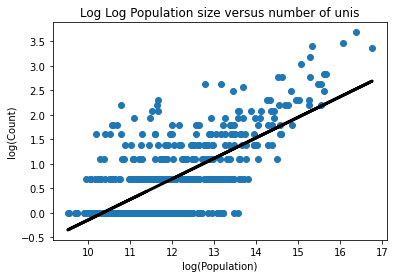

In [274]:
loglogfit(pop_per_msa, unis_per_msa, title='Log Log Population size versus number of unis')

In [80]:
msa_papers = {}

In [81]:
msa_syllabi = {}

In [82]:
for msa in msa_unis:
    msa_papers[msa] = 0
    msa_syllabi[msa] = 0
    for uni in msa_unis[msa]:
        try:
            msa_papers[msa] += research_orgs[teaching_to_research_match[uni]][2]
        except:
            print("missing research" + uni)
        try:
            msa_syllabi[msa] += teaching_orgs[uni][2]
        except:
            print("missing teaching" + uni)
    if msa_papers[msa] == 0:
        del msa_papers[msa]
    if msa_syllabi[msa] == 0:
        del msa_syllabi[msa]

missing researchUniversity of Akron Main Campus
missing researchAlbany Law School
missing researchAlbany Law School
missing researchUnion College-Schenectady
missing researchUnion Graduate College
missing researchWalsh College of Accountancy and Business Administration
missing researchUniversity of New Mexico-Main Campus
missing researchAlexandria Technical & Community College
missing researchCedar Crest College
missing researchNorthampton County Area Community College
missing researchAnderson University-Anderson
missing researchConcordia University-Ann Arbor
missing researchMiami University-Oxford
missing researchFox Valley Technical College
missing researchAtlanta's John Marshall Law School
missing researchMorehouse School of Medicine
missing teachingMorehouse School of Medicine
missing researchChattahoochee Technical College
missing researchWashington State Community College
missing teachingWashington State Community College
missing researchGreen River College
missing researchCayuga

In [107]:
papers_per_msa = []
pop_per_msa = []

In [108]:
for msa in msa_pop:
    try:
        papers_per_msa.append(msa_papers[msa])
        pop_per_msa.append(msa_pop[msa])
    except KeyError:
        print(msa)
        continue

Akron, OH Metro Area
Altoona, PA Metro Area
Anchorage, AK Metro Area
Anderson, SC Metro Area
Anniston-Oxford, AL Metro Area
Athens-Clarke County, GA Metro Area
Atlantic City-Hammonton, NJ Metro Area
Auburn-Opelika, AL Metro Area
Augusta-Richmond County, GA-SC Metro Area
Bangor, ME Metro Area
Barnstable Town, MA Metro Area
Battle Creek, MI Metro Area
Bay City, MI Metro Area
Brownsville-Harlingen, TX Metro Area
Carson City, NV Metro Area
Charlottesville, VA Metro Area
Crestview-Fort Walton Beach-Destin, FL Metro Area
Cumberland, MD-WV Metro Area
Dothan, AL Metro Area
El Centro, CA Metro Area
Fargo, ND-MN Metro Area
Fond du Lac, WI Metro Area
Glens Falls, NY Metro Area
Great Falls, MT Metro Area
Gulfport-Biloxi, MS Metro Area
Hanford-Corcoran, CA Metro Area
Harrisburg-Carlisle, PA Metro Area
Hinesville-Fort Stewart, GA Metro Area
Honolulu, HI Metro Area
Hot Springs, AR Metro Area
Idaho Falls, ID Metro Area
Janesville, WI Metro Area
Johnstown, PA Metro Area
Jonesboro, AR Metro Area
Kennewi

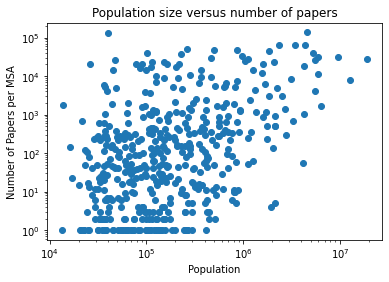

In [85]:
plt.xscale('log')
plt.yscale('log')
plt.title('Population size versus number of papers')
plt.xlabel('Population')
plt.ylabel('Number of Papers per MSA')
plt.scatter(pop_per_msa, papers_per_msa)

Score on fitting data: 0.18598702805024836
Coefficient value: [0.98349173]


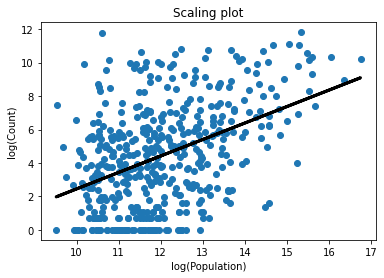

In [109]:
loglogfit(pop_per_msa, papers_per_msa, title=)

In [111]:
syllabi_per_msa = []
pop_per_msa = []

In [112]:
for msa in msa_pop:
    try:
        syllabi_per_msa.append(msa_syllabi[msa])
        pop_per_msa.append(msa_pop[msa])
    except KeyError:
        print(msa)
        continue

Altoona, PA Metro Area
Anchorage, AK Metro Area
Athens-Clarke County, GA Metro Area
Atlantic City-Hammonton, NJ Metro Area
Augusta-Richmond County, GA-SC Metro Area
Bangor, ME Metro Area
Barnstable Town, MA Metro Area
Bay City, MI Metro Area
Brownsville-Harlingen, TX Metro Area
Carson City, NV Metro Area
Crestview-Fort Walton Beach-Destin, FL Metro Area
Dothan, AL Metro Area
El Centro, CA Metro Area
Glens Falls, NY Metro Area
Great Falls, MT Metro Area
Gulfport-Biloxi, MS Metro Area
Hanford-Corcoran, CA Metro Area
Hinesville-Fort Stewart, GA Metro Area
Honolulu, HI Metro Area
Kennewick-Pasco-Richland, WA Metro Area
Lexington-Fayette, KY Metro Area
Louisville/Jefferson County, KY-IN Metro Area
Madera-Chowchilla, CA Metro Area
Michigan City-La Porte, IN Metro Area
Naples-Marco Island, FL Metro Area
Ocean City, NJ Metro Area
Palm Bay-Melbourne-Titusville, FL Metro Area
Palm Coast, FL Metro Area
Pascagoula, MS Metro Area
Pine Bluff, AR Metro Area
Port St. Lucie, FL Metro Area
Punta Gorda, 

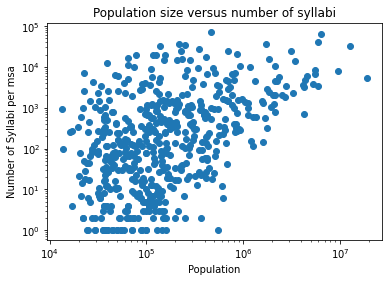

In [88]:
plt.xscale('log')
plt.yscale('log')
plt.title('Population size versus number of syllabi')
plt.xlabel('Population')
plt.ylabel('Number of Syllabi per msa')
plt.scatter(pop_per_msa, syllabi_per_msa)

Score on fitting data: 0.22050923367046438
Coefficient value: [0.96062015]


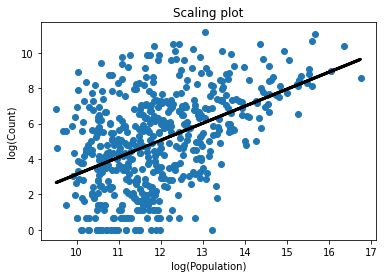

In [113]:
loglogfit(pop_per_msa, syllabi_per_msa)

### Other Scaling Measures for Cities with Research and Teaching

1. Extent of diversity in terms of overlap with center of mass of state and of USA

In [114]:
 research_usa = []

In [115]:
for city in research_cities:
    research_usa.append(research_cities[city][0])

In [116]:
com_usa_research = np.mean(research_usa, axis=0)

In [117]:
teaching_usa = []

In [118]:
for city in teaching_cities:
    teaching_usa.append(teaching_cities[city][0])

In [119]:
com_usa_teaching = np.mean(teaching_usa, axis=0)

In [161]:
state_vectors_res, state_vectors_teach = {}, {}

In [162]:
reader = csv.reader(open("../saved_data_structures/state_unis.csv"))

In [163]:
states = {}

In [164]:
for k,v in reader:
    states[k] = eval(v)

In [167]:
for state in states:
    state_vectors_res[state] = []
    state_vectors_teach[state] = []
    for uni in states[state]:
        teaching_vector, research_vector = get_entity_vector(uni)
        if teaching_vector is not None:
            state_vectors_teach[state].append(teaching_vector)
        else:
            print("missing uni in teaching " + uni)

        if research_vector is not None:
            state_vectors_res[state].append(research_vector)
        else:
            print("missing uni in research " + uni)
    
    state_vectors_res[state] = np.mean(state_vectors_res[state], axis=0)
    state_vectors_teach[state] = np.mean(state_vectors_teach[state], axis=0)

missing uni in research McLennan Community College
missing uni in research Texas A & M International University
missing uni in research Alvin Community College
missing uni in research Collin County Community College District
missing uni in research Northeast Texas Community College
missing uni in research Victoria College
missing uni in research Clarendon College
missing uni in research Lone Star College System
missing uni in research Tarrant County College District
missing uni in research San Jacinto Community College
missing uni in research Central Texas College
missing uni in research Texarkana College
missing uni in research Panola College
missing uni in research Ranger College
missing uni in research Western Texas College
missing uni in research Houston Graduate School of Theology
missing uni in research Frank Phillips College
missing uni in research Texas Woman's University
missing uni in teaching Southwestern Adventist University
missing uni in research Southwestern Adventist Un

TypeError: can only concatenate str (not "NoneType") to str

In [236]:
msa_state_difference_r = []
msa_usa_difference_r = []
msa_state_difference_t = []
msa_usa_difference_t = []

In [237]:
msa_pops_state_r = []
msa_pops_state_t = []
msa_pops_usa_r = []
msa_pops_usa_t = []


In [238]:
state_r_error = []
state_t_error = []
usa_r_error = []
usa_t_error = []

In [239]:
for msa in msa_research_vectors:
    try:
        city, state_metro = msa.split(',')
    except ValueError:
        city, _, state_metro = msa.split(',')
    try:
        state, _ = state_metro.split('Metro')
    except ValueError:
        state, _ = state_metro.split('Micro')
    
    state = state.strip()
    if '-' in state:
        states_ = state.split('-')
        state_vec_r = []
        state_vec_t = []
        for state_ in states_:
            try:
                state_vec_r.append(state_vectors_res[state_])
                state_vec_t.append(state_vectors_res[state_])
            except KeyError:
                print(msa)
                continue
        state_vec_r = np.mean(state_vec_r, axis=0)
        state_vec_t = np.mean(state_vec_t, axis=0)
    else:
        try:
            state_vec_r = state_vectors_res[state]
            state_vec_t = state_vectors_teach[state]
        except KeyError:
            print(msa)
            continue
    
    state_diff_r = angle_between(msa_research_vectors[msa], state_vec_r)[0]
    usa_diff_r = angle_between(msa_research_vectors[msa], com_usa_research)[0] 
    
    state_diff_t = angle_between(msa_teaching_vectors[msa], state_vec_t)[0]
    usa_diff_t = angle_between(msa_teaching_vectors[msa], com_usa_teaching)[0]
    
    if type(state_diff_r) != np.float64:
        state_r_error.append(msa)
    else:
        msa_state_difference_r.append(state_diff_r)
        msa_pops_state_r.append(msa_pop[msa])

    if type(state_diff_t) != np.float64:
        state_t_error.append(msa)
    else:
        msa_state_difference_t.append(state_diff_t)
        msa_pops_state_t.append(msa_pop[msa])        

    if type(usa_diff_r) != np.float64:
        usa_r_error.append(msa)
    else:
        msa_usa_difference_r.append(usa_diff_r)
        msa_pops_usa_r.append(msa_pop[msa])

    if type(usa_diff_t) != np.float64:
        usa_t_error.append(msa)
    else:
        msa_usa_difference_t.append(usa_diff_t)
        msa_pops_usa_t.append(msa_pop[msa]) 
        

Spokane, WS Metro Area
Liberal, KA Micro Area
Natchitoches, La Micro Area


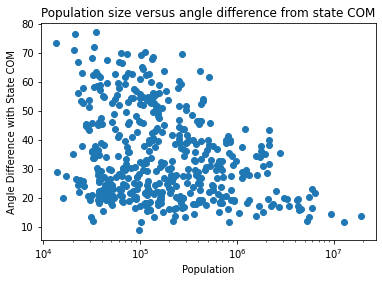

In [253]:
plt.xscale('log')
plt.title('Population size versus angle difference from state COM for Reserch')
plt.xlabel('Population')
plt.ylabel('Angle Difference with State COM')
plt.scatter(msa_pops_state_r, msa_state_difference_r)

Score on fitting data: 0.09165553062848297
Coefficient value: [-0.10120209]


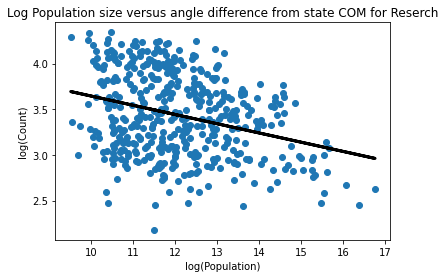

In [275]:
loglogfit(msa_pops_state_r, msa_state_difference_r, title='Log Population size versus angle difference from state COM for Reserch')

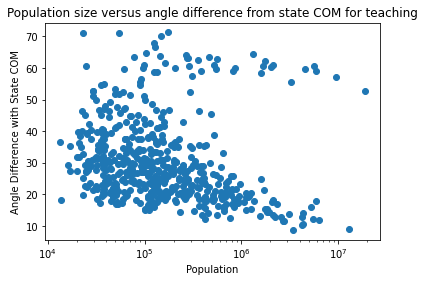

In [276]:
plt.xscale('log')
plt.title('Population size versus angle difference from state COM for teaching')
plt.xlabel('Population')
plt.ylabel('Angle Difference with State COM')
plt.scatter(msa_pops_state_t, msa_state_difference_t)

Score on fitting data: 0.09800204653353173
Coefficient value: [-0.09652243]


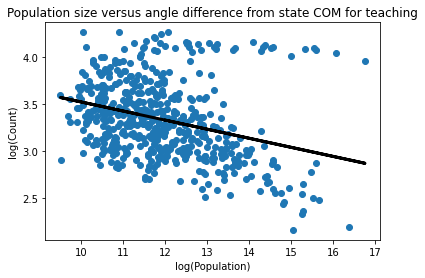

In [277]:
loglogfit(msa_pops_state_t, msa_state_difference_t, title='Population size versus angle difference from state COM for teaching')

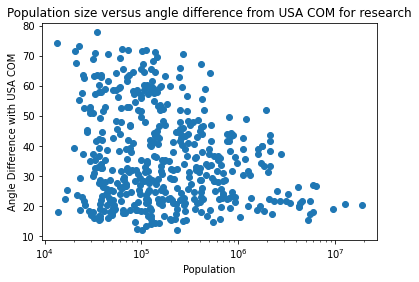

In [278]:
plt.xscale('log')
plt.title('Population size versus angle difference from USA COM for research')
plt.xlabel('Population')
plt.ylabel('Angle Difference with USA COM')
plt.scatter(msa_pops_usa_r, msa_usa_difference_r)

Score on fitting data: 0.03830186597890439
Coefficient value: [-0.06395844]


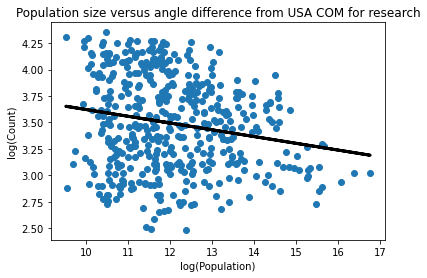

In [279]:
loglogfit(msa_pops_usa_r, msa_usa_difference_r, title='Population size versus angle difference from USA COM for research')

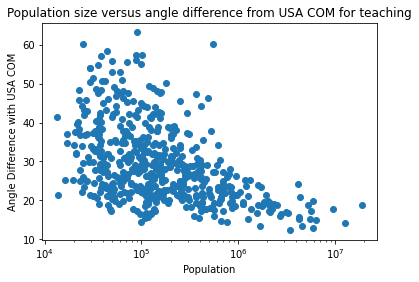

In [281]:
plt.xscale('log')
plt.title('Population size versus angle difference from USA COM for teaching')
plt.xlabel('Population')
plt.ylabel('Angle Difference with USA COM')
plt.scatter(msa_pops_usa_t, msa_usa_difference_t)

Score on fitting data: 0.2803338488890875
Coefficient value: [-0.13040706]


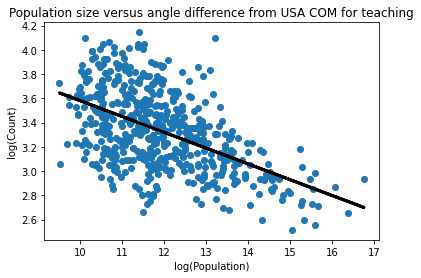

In [282]:
loglogfit(msa_pops_usa_t, msa_usa_difference_t, title='Population size versus angle difference from USA COM for teaching')

#### Findings so far:

Angle of difference as being useful?

Avg angle of difference as a metric: useful? Is the average of all the angles between pairs of unis in an MSA.

Avg angle of difference for research: for city - 38, for msa - 41, for state - 48, for country - 54. How do I construct a statistically significant experiment to demonstrate that spatial aggregation occurs?
Similar trend not observed in teaching - again, how to demonstrate these are different?

As population increases, there is a funnel or move towards an 'average' average angle of difference for a city
As population increases, there is an increase in number of unis as well as number of papers and syllabi

unis which differ in research likely to differ in teaching (spatial)
how to use tier information in a useful way? rankings and scaling?
within tiers - research in higher tiers are more different, lower tiers are similar


Questions:

1) What else can I measure with the texts associated with cities? 
2) Any kind of gravity effect or flow can we measure? How would having vectors for each year change the analysis?
3) How do I measure scaling with unis? I saw a previous paper which uses the total number of individual authors - since I threw away author information, as well as that only authors likely isn't the best measure, how would you measure scaling for universities?
4) Jobs data (finally) wrangled. Will run same analysis, I am working with city and organisation wise job postings. Similar questions - what can we tell from texts? Diversity in job postings?
